In [1]:
## file for video segmentation using prompt

In [1]:
from mb_annotation.utils import video_to_images

In [12]:
image_list = video_to_images(video_path="./test_data/test_video.mp4",image_save_path="./test_data/video_images",image_name="0",
                             frame_interval=1,duration=10,image_format="jpg");

Converting video to images:  39%|███▉      | 301/773 [00:09<00:15, 30.99it/s]

Video duration reached
Total frames: 773
Current frame: 301
Current time: 10.033333333333333


In [16]:
## finding bounding box of item

In [17]:
from mb_annotation.bounding_box import google_model,generate_bounding_box,add_bounding_box
from mb_annotation.utils import load_env_file
import os

load_env_file('./env');
model = google_model(model="gemini-1.5-pro-latest",api_key=os.environ.get("GOOGLE_API_KEY"))


/home/malav/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
res =generate_bounding_box(model,image_path="./test_data/video_images/0_0005.jpg",prompt='Return bounding boxes of container, for each only one return [xmin,ymin, xmax, ymax]')

In [41]:
res.text

'{\n  "container": [5,73,994,949]\n}\n'

In [42]:
import json
if type(res) != dict:
    try:
        res = json.loads(res.text)
    except:
        res = eval(res.text)
print(res)

{'container': [5, 73, 994, 949]}


In [43]:
img_bb,value = add_bounding_box(image_path="./test_data/video_images/0_0005.jpg",bounding_box=res,label="container",box_resize=True,show=False)
print(value)

[5, 140, 1073, 1822]


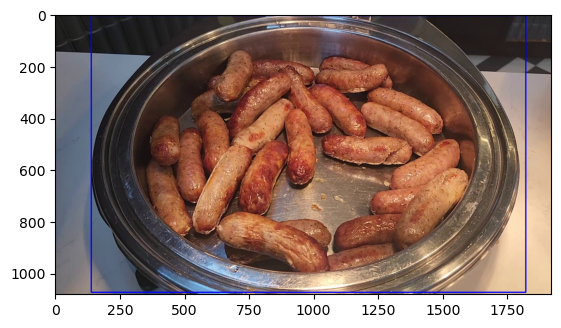

In [44]:
import matplotlib.pyplot as plt
plt.imshow(img_bb)
plt.show()

In [4]:
## loading the predictor

In [6]:
from sam2.build_sam import build_sam2_video_predictor

model_cfg= './sam2_hiera_s.yaml'
sam2_checkpoint = '/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt'
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device='cpu')


/home/malav/.local/lib/python3.11/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [18]:
inference_state = predictor.init_state(video_path='./test_data/video_images')

frame loading (JPEG): 100%|██████████| 296/296 [00:10<00:00, 27.99it/s]


In [14]:
## reset any previous state 

predictor.reset_state(inference_state)


In [15]:
import numpy as np
from PIL import Image
from matplotlib.pyplot import plot as plt

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

/home/malav/.local/lib/python3.11/site-packages/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/home/malav/.local/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


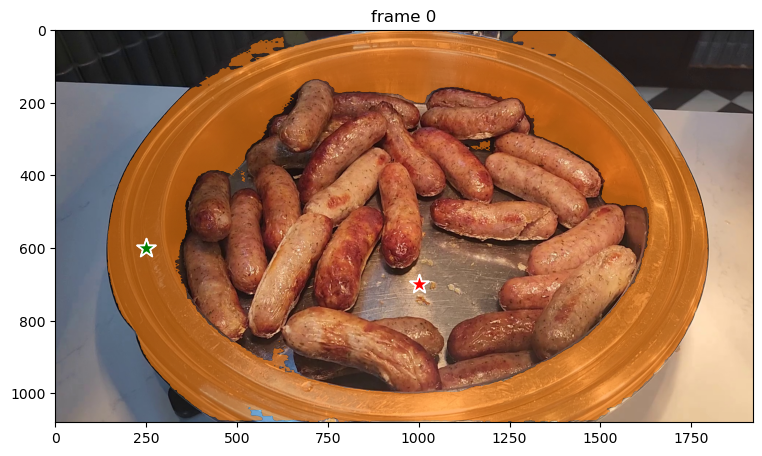

In [49]:
test_frame=0
ann_obj_id = 1 
points = np.array([[250, 600],[1000,700]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0], np.int32)

box = np.array([ 140,5,1822,1073], dtype=np.float32)
prompts={}
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=test_frame,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {test_frame}")
plt.imshow(Image.open('./test_data/video_images/0_0005.jpg'))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [53]:
from os import listdir
from os.path import isfile, join
frame_names = [f for f in listdir('./test_data/video_images') if isfile(join('./test_data/video_images', f))]
frame_names = sorted(frame_names)

In [54]:
frame_names[:3]

['0_0005.jpg', '0_0006.jpg', '0_0007.jpg']

propagate in video:   0%|          | 0/296 [00:00<?, ?it/s]/home/malav/.local/lib/python3.11/site-packages/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/home/malav/.local/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 296/296 [15:42<00:00,  3.18s/it]


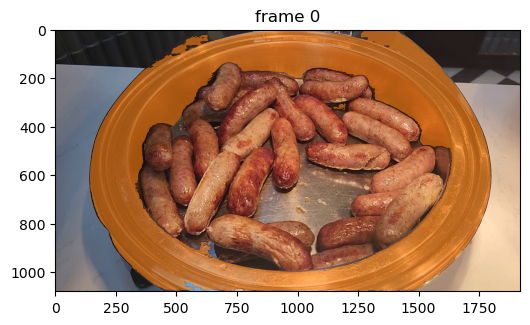

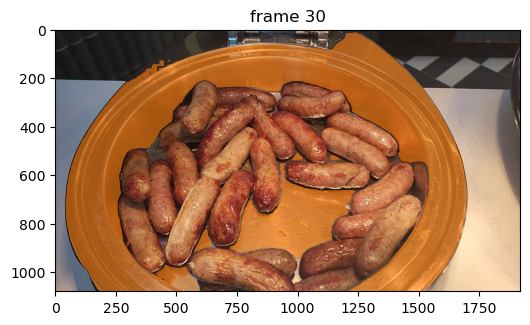

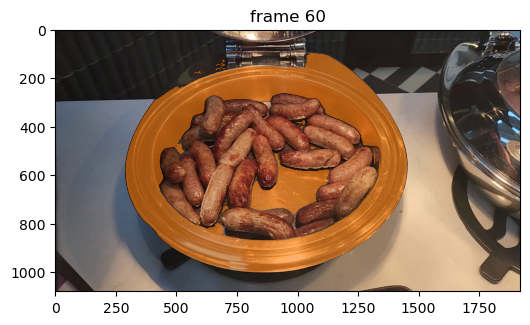

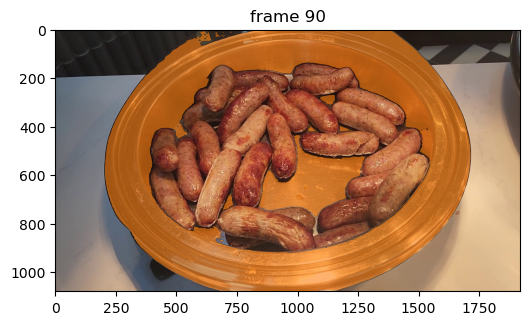

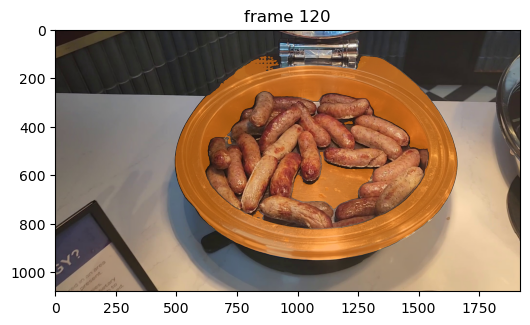

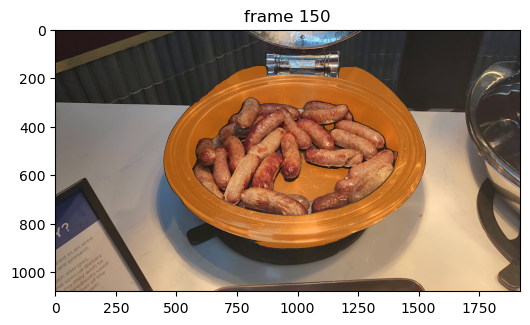

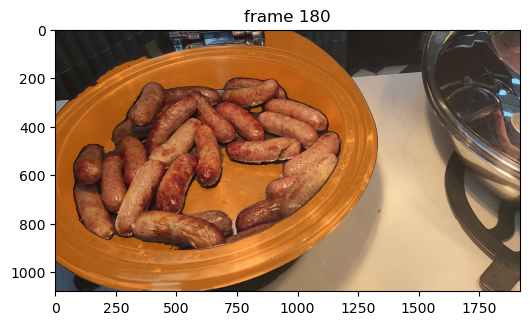

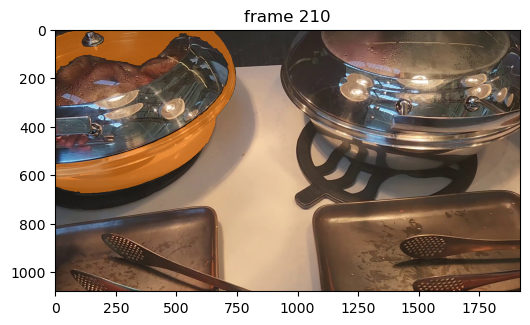

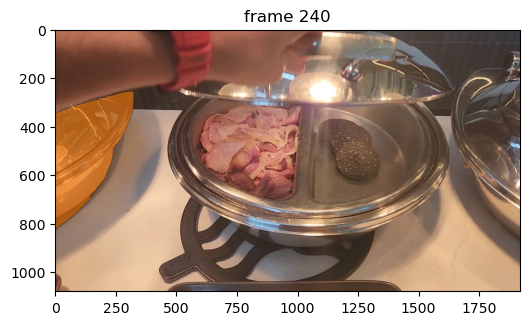

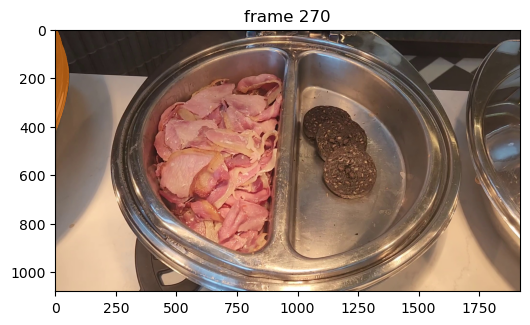

In [55]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join('./test_data/video_images', frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)